# Predict BTC price direction - Random Forest Classifier

In [100]:
# Import libraries
import numpy as np
import pandas as pd
from pathlib import Path
import os
import requests
import datetime

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

%matplotlib inline

In [102]:
# Read in annual coin metrics from csv
metrics_2021 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_1.csv', parse_dates=True)
metrics_2020 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_2.csv', parse_dates=True)
metrics_2019 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_3.csv', parse_dates=True)
metrics_2018 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_4.csv', parse_dates=True)
metrics_2017 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_5.csv', parse_dates=True)
metrics_2016 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_6.csv', parse_dates=True)
metrics_2015 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_7.csv', parse_dates=True)
metrics_2014 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_8.csv', parse_dates=True)
metrics_2013 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_9.csv', parse_dates=True)
metrics_2012 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_10.csv', parse_dates=True)
metrics_2011 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_11.csv', parse_dates=True)
metrics_2010 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_12.csv', parse_dates=True)
metrics_2009 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_13.csv', parse_dates=True)

In [103]:
# Read in combined BTC Google trends data
btc_google_trends = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_google_trends/btc_trends_combined.csv', parse_dates=True)
btc_google_trends.reset_index(inplace=True)
btc_google_trends.rename(columns={'date':'time', 'bitcoin':'BTC_Trends'},inplace=True)
btc_google_trends = btc_google_trends.drop(columns='index')
btc_google_trends['time'] = pd.to_datetime(btc_google_trends['time']).dt.date
btc_google_trends = btc_google_trends.set_index('time')
btc_google_trends.tail()

,BTC_Trends
time,
2021-07-30,20
2021-07-31,21
2021-08-01,21
2021-08-02,19
2021-08-03,19


In [104]:
# Concat all csv files  and print combined csv
combined = pd.concat([metrics_2009,metrics_2010,metrics_2011,metrics_2012,metrics_2013,metrics_2014,metrics_2015,metrics_2016,metrics_2017,metrics_2018,metrics_2019,metrics_2020,metrics_2021], axis=0)
combined_df = pd.DataFrame(combined)
combined_df = combined_df.drop_duplicates(keep='first')
combined_df.tail()

,time,asset,AdrActCnt,CapMVRVCur,CapMrktCurUSD,HashRate,NVTAdj,PriceUSD,SplyCur,TxCnt,TxTfrValAdjUSD,VelCur1yr
211,2021-07-31 00:00:00+00:00,btc,720022,2.098153,7.845650e+11,1.126706e+08,178.651798,41793.313748,1.877250e+07,204354,4.391587e+09,11.383878
212,2021-08-01 00:00:00+00:00,btc,695892,2.006838,7.503559e+11,1.109758e+08,88.007444,39968.968954,1.877346e+07,190234,8.526051e+09,11.373743
213,2021-08-02 00:00:00+00:00,btc,899861,1.972934,7.379108e+11,1.030490e+08,101.382469,39304.186284,1.877436e+07,236019,7.278485e+09,11.491496
214,2021-08-03 00:00:00+00:00,btc,820918,1.922865,7.188885e+11,1.217851e+08,82.308751,38288.825398,1.877541e+07,246833,8.734047e+09,11.454489
215,2021-08-04 00:00:00+00:00,btc,842870,1.995698,7.468054e+11,9.800460e+07,57.964298,39773.911349,1.877626e+07,237723,1.288389e+10,11.498698


In [105]:
combined_df.isnull().sum()

time                0
asset               0
AdrActCnt           0
CapMVRVCur        561
CapMrktCurUSD     561
HashRate            6
NVTAdj            260
PriceUSD          561
SplyCur             0
TxCnt               0
TxTfrValAdjUSD    561
VelCur1yr           6
dtype: int64

In [106]:
combined_df.dropna(inplace=True)
combined_df.isnull().sum()

time              0
asset             0
AdrActCnt         0
CapMVRVCur        0
CapMrktCurUSD     0
HashRate          0
NVTAdj            0
PriceUSD          0
SplyCur           0
TxCnt             0
TxTfrValAdjUSD    0
VelCur1yr         0
dtype: int64

In [107]:
# Remove timestamp in time column
combined_df['time'] = pd.to_datetime(combined_df['time']).dt.date
combined_df = combined_df.set_index('time')
combined.to_csv('resources/btc_annual_metrics/combined.csv')

In [108]:
# Concat metrics and google trends data
combined_df = pd.concat([combined_df,btc_google_trends],axis=1).dropna()
combined_df = combined_df.reset_index()
combined_df = combined_df.rename(columns={'index':'time'})
combined_df = combined_df.set_index('time')
combined_df.tail()

,asset,AdrActCnt,CapMVRVCur,CapMrktCurUSD,HashRate,NVTAdj,PriceUSD,SplyCur,TxCnt,TxTfrValAdjUSD,VelCur1yr,BTC_Trends
time,,,,,,,,,,,,
2021-07-30,btc,841162.0,2.099162,7.844553e+11,1.128249e+08,75.598150,41789.667098,1.877151e+07,250833.0,1.037665e+10,11.390693,20.0
2021-07-31,btc,720022.0,2.098153,7.845650e+11,1.126706e+08,178.651798,41793.313748,1.877250e+07,204354.0,4.391587e+09,11.383878,21.0
2021-08-01,btc,695892.0,2.006838,7.503559e+11,1.109758e+08,88.007444,39968.968954,1.877346e+07,190234.0,8.526051e+09,11.373743,21.0
2021-08-02,btc,899861.0,1.972934,7.379108e+11,1.030490e+08,101.382469,39304.186284,1.877436e+07,236019.0,7.278485e+09,11.491496,19.0
2021-08-03,btc,820918.0,1.922865,7.188885e+11,1.217851e+08,82.308751,38288.825398,1.877541e+07,246833.0,8.734047e+09,11.454489,19.0


In [109]:
# Read in momentum (RSI) data
rsi_btc = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/rsi_btc.csv', parse_dates=True, index_col='time')
rsi_btc.head()

,RSI_14
time,
2010-08-01,39.307936
2010-08-02,38.416515
2010-08-03,38.433124
2010-08-04,35.864378
2010-08-05,41.466498


In [110]:
# Read in momentum ROC data
roc_btc = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/roc_btc.csv', parse_dates=True, index_col='time')
roc_btc.head()

,ROC_14
time,
2010-08-01,-28.821062
2010-08-02,-25.742574
2010-08-03,-19.700856
2010-08-04,-28.003890
2010-08-05,4.327433


In [111]:
# Read in Money Flow Index (MFI) data
mfi_btc = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/mfi_btc.csv', parse_dates=True)
mfi_btc = mfi_btc.rename(columns={'Date':'time'})
mfi_btc['time'] = pd.to_datetime(mfi_btc['time']).dt.date
mfi_btc = mfi_btc.set_index('time').dropna()
mfi_btc.head()

,MFI_14
time,
2014-09-30,44.385818
2014-10-01,47.723240
2014-10-02,49.685391
2014-10-03,50.938482
2014-10-04,41.150663


In [112]:
# Create model features dataframe
features_btc = pd.concat([combined_df,rsi_btc, roc_btc, mfi_btc], axis=1).dropna()
features_btc.head()

,asset,AdrActCnt,CapMVRVCur,CapMrktCurUSD,HashRate,NVTAdj,PriceUSD,SplyCur,TxCnt,TxTfrValAdjUSD,VelCur1yr,BTC_Trends,RSI_14,ROC_14,MFI_14
time,,,,,,,,,,,,,,,
2014-09-30,btc,217696.0,1.114030,5.189547e+09,263623.410750,71.072545,389.264040,1.333169e+07,77225.0,7.301761e+07,19.739709,43.0,35.378552,-16.139014,44.385818
2014-10-01,btc,212669.0,1.097090,5.106313e+09,267069.468406,73.755278,382.909366,1.333556e+07,79127.0,6.923318e+07,19.691883,47.0,33.968761,-16.091191,47.723240
2014-10-02,btc,183913.0,1.068432,4.969126e+09,237777.978323,80.488080,372.525699,1.333901e+07,73147.0,6.173741e+07,19.636771,39.0,31.742875,-12.732945,49.685391
2014-10-03,btc,177578.0,1.029412,4.772214e+09,251562.208951,70.436763,357.665714,1.334266e+07,74077.0,6.775175e+07,19.607065,45.0,28.831228,-9.197446,50.938482
2014-10-04,btc,172315.0,0.948455,4.388683e+09,265346.439578,67.045034,328.826113,1.334651e+07,66820.0,6.545873e+07,19.587453,41.0,24.193128,-20.001694,41.150663


In [113]:
features_btc.to_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/features_btc.csv')

<AxesSubplot:title={'center':'EMA BTC'}, xlabel='time', ylabel='BTC Price ($)'>

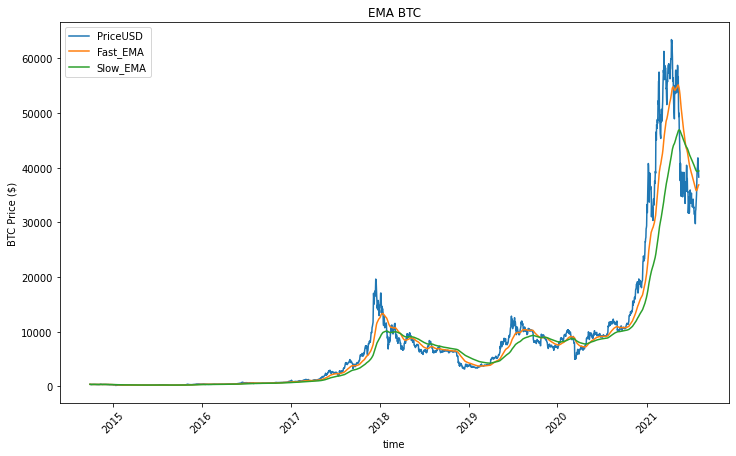

In [114]:
# Set short and long windows for EMA (Exponential Moving Average) to create trading signals features
short_window = 20
long_window = 50

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
features_btc['Fast_EMA'] = features_btc['PriceUSD'].ewm(halflife=short_window).mean()
features_btc['Slow_EMA'] = features_btc['PriceUSD'].ewm(halflife=long_window).mean()

# Plot the EMA of ETH closing prices
features_btc[['PriceUSD', 'Fast_EMA', 'Slow_EMA']].plot(figsize=(12,7), title='EMA BTC', ylabel='BTC Price ($)', rot=45) 

In [115]:
# Construct a crossover trading signal
features_btc['Crossover_Long'] = np.where(features_btc['Fast_EMA'] > features_btc['Slow_EMA'], 1.0, 0.0)
features_btc['Crossover_Short'] = np.where(features_btc['Fast_EMA'] < features_btc['Slow_EMA'],-1.0, 0.0)
features_btc['Crossover_Signal'] = features_btc['Crossover_Long'] + features_btc['Crossover_Short']

In [116]:
# Calculate daily return
features_btc['Daily_Return'] = features_btc['PriceUSD'].pct_change()

In [117]:
# Construct the dependent variable where if daily return is greater than 0, then 1, else, 0.
features_btc['Positive_Return'] = np.where(features_btc['Daily_Return'] > 0, 1.0, 0.0)

features_btc = features_btc.dropna()

# Convert date to str to set test and train windows 
features_btc.index = pd.to_datetime(features_btc.index, format = '%Y/%m/%d')
features_btc.tail()

,asset,AdrActCnt,CapMVRVCur,CapMrktCurUSD,HashRate,NVTAdj,PriceUSD,SplyCur,TxCnt,TxTfrValAdjUSD,...,RSI_14,ROC_14,MFI_14,Fast_EMA,Slow_EMA,Crossover_Long,Crossover_Short,Crossover_Signal,Daily_Return,Positive_Return
time,,,,,,,,,,,,,,,,,,,,,
2021-07-30,btc,841162.0,2.099162,7.844553e+11,1.128249e+08,75.598150,41789.667098,1.877151e+07,250833.0,1.037665e+10,...,74.480983,32.852373,85.733282,36427.086538,39384.494946,0.0,-1.0,-1.0,0.042496,1.0
2021-07-31,btc,720022.0,2.098153,7.845650e+11,1.126706e+08,178.651798,41793.313748,1.877250e+07,204354.0,4.391587e+09,...,74.488054,32.475524,90.484656,36609.879937,39417.657866,0.0,-1.0,-1.0,0.000087,1.0
2021-08-01,btc,695892.0,2.006838,7.503559e+11,1.109758e+08,88.007444,39968.968954,1.877346e+07,190234.0,8.526051e+09,...,64.812531,26.054441,83.305270,36724.302840,39425.247929,0.0,-1.0,-1.0,-0.043652,0.0
2021-08-02,btc,899861.0,1.972934,7.379108e+11,1.030490e+08,101.382469,39304.186284,1.877436e+07,236019.0,7.278485e+09,...,61.669039,27.266096,81.204203,36812.183141,39423.581237,0.0,-1.0,-1.0,-0.016632,0.0
2021-08-03,btc,820918.0,1.922865,7.188885e+11,1.217851e+08,82.308751,38288.825398,1.877541e+07,246833.0,8.734047e+09,...,57.112743,28.629911,79.522234,36862.482997,39407.958718,0.0,-1.0,-1.0,-0.025833,0.0


In [119]:
# Select model features and timeframe for train data
X = features_btc[['AdrActCnt','CapMrktCurUSD','CapMVRVCur','HashRate','NVTAdj','TxCnt','TxTfrValAdjUSD','VelCur1yr','Crossover_Signal','BTC_Trends','RSI_14','ROC_14','MFI_14']]
X_train = X[:'2020']

In [120]:
# Select prediction variable and timeframe for train data
y = features_btc['Positive_Return']
y_train = y[:'2020']

In [121]:
# Define timeframe for testing data
X_test = X['2021':]
y_test = y['2021':]

In [122]:
# Create the StandardScaler instance
scaler = StandardScaler()

In [123]:
# Fit the Standard Scaler with the training data
X_scaler = scaler.fit(X_train)

In [124]:
# Scale the training data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [140]:
# Perform the grid search for the optimal set of tree parameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

n_estimators = [20,500]
max_depth= [5,10]
num_folds = 10
scoring = 'accuracy'

criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, \
  criterion = criterion )

model = RandomForestClassifier(n_jobs=-1)

kfold = KFold(n_splits=num_folds, random_state=None)
grid = GridSearchCV(estimator=model, param_grid=param_grid, \
  scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_,\
  grid_result.best_params_))

Best: 0.611235 using {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 500}


In [149]:
# Define the model using optimized settings (also use if you want to run without optimizer above)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

model = RandomForestClassifier(n_jobs=-1)
model = RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=500, n_jobs=-1)

In [150]:
# Fit the model
model = model.fit(X_train_scaled, y_train)

In [151]:
# Making predictions using the testing data
predictions = model.predict(X_test_scaled)

In [152]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [153]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,62,40
Actual 1,40,73


Accuracy Score : 0.627906976744186
Classification Report
              precision    recall  f1-score   support

         0.0       0.61      0.61      0.61       102
         1.0       0.65      0.65      0.65       113

    accuracy                           0.63       215
   macro avg       0.63      0.63      0.63       215
weighted avg       0.63      0.63      0.63       215



In [154]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe
Results = y_test.to_frame()
Results["Predicted Value"] = predictions
Results[-20:]

,Positive_Return,Predicted Value
time,,
2021-07-15,0.0,0.0
2021-07-16,0.0,0.0
2021-07-17,1.0,0.0
2021-07-18,1.0,0.0
2021-07-19,0.0,0.0
2021-07-20,0.0,0.0
2021-07-21,1.0,0.0
2021-07-22,1.0,0.0
2021-07-23,1.0,1.0


In [155]:
# List the features sorted in descending order by feature importance
importances = model.feature_importances_
sorted(zip(model.feature_importances_, X.columns), reverse=True)

[(0.19215635643141307, 'RSI_14'),
 (0.10273894225282076, 'ROC_14'),
 (0.09656265949110267, 'MFI_14'),
 (0.07833748606787917, 'NVTAdj'),
 (0.07321262028642775, 'TxCnt'),
 (0.0703952650937432, 'AdrActCnt'),
 (0.07025706397933407, 'CapMVRVCur'),
 (0.06457743865806499, 'HashRate'),
 (0.06445646630640921, 'VelCur1yr'),
 (0.0642119855044832, 'TxTfrValAdjUSD'),
 (0.060849539065167046, 'CapMrktCurUSD'),
 (0.058739868157971345, 'BTC_Trends'),
 (0.0035043087051834986, 'Crossover_Signal')]

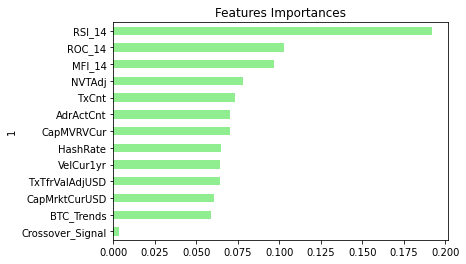

In [156]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(model.feature_importances_,    X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)

importances_sorted = importances_df.sort_values(by=
'Feature Importances')

importances_plot = importances_sorted.plot(kind='barh', color='lightgreen', title='Features Importances', legend=False)

In [ ]:
# RSI is the most dominant feature which shows that BTC price is primarily determined by momentum.